# Seminar 4 (Momentum)

## Problem 1: two-dimensional classification

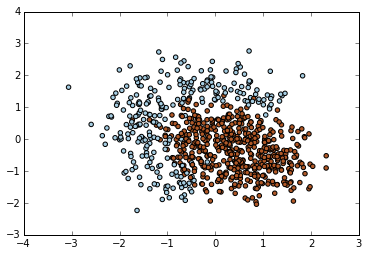

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > 0)
X = X[ind,:]
m = np.array([[1, 1], [-2, 1]])
X = X.dot(m)
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

Implement classification with hinge loss.
You should use up to the second order terms of X for your classifier, as in function f.

In [89]:
def transform(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1
    return X_

def f(X, w):
    X_ = transform(X)
    return np.dot(X_, w)

def classify(X, w):
    return np.sign(f(X, w))

def compute_loss(X, y, w):
    return np.mean(np.maximum(0, 1 - f(X, w) * y))

def compute_grad(X, y, w):
    X_ = transform(X)
    y_ = np.dot(X_, w)
    grad = np.zeros(6)
    for x, y, x_, y_ in zip(X, y, X_, y_):
        if y_ * y < 1:
            grad += -x_ * y
    return grad / len(X)

In [90]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def plot_points(X, y, w):
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    display.clear_output(wait=True)
    display.display(plt.gcf())
def plot_loss(loss):
    plt.clf()
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    plt.show()

Find an optimal learning rate for gradient descent for given batch size

**Don't change the batch size!**

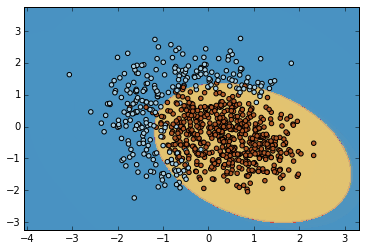

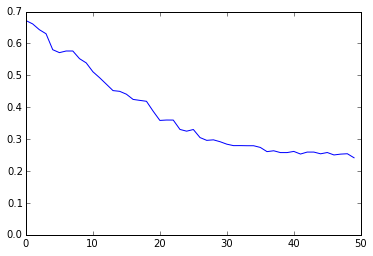

In [91]:
w = np.array([0,0,0,0,0,1])

alpha = 0.05 # learning rate

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    plot_points(X[ind,:], y[ind], w)
    loss[i] = compute_loss(X, y, w)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

plot_points(X, y, w)
plot_loss(loss)


Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

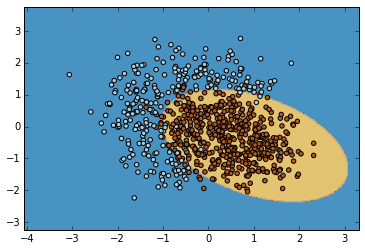

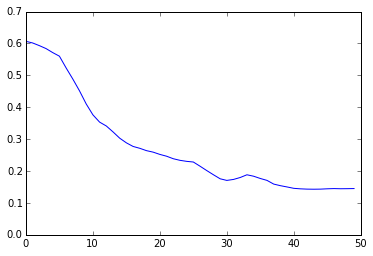

In [93]:
w = np.array([1,0,0,0,0,0])
v = np.array([0,0,0,0,0,0])

alpha = 0.05 # learning rate
mu    = 0.9 # momentum

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    plot_points(X[ind,:], y[ind], w)
    loss[i] = compute_loss(X, y, w)
    
    v = mu * v - alpha * compute_grad(X[ind,:], y[ind], w)
    w = w + v

plot_points(X, y, w)
plot_loss(loss)

Finally, try Nesterov's accelerated gradient

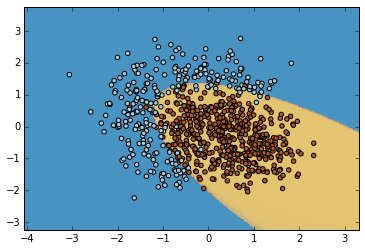

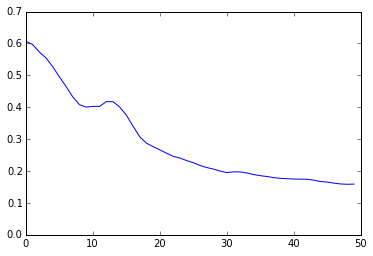

In [98]:
w = np.array([1,0,0,0,0,0])
v = np.array([0,0,0,0,0,0])

alpha = 0.05 # learning rate
mu    = 0.9 # momentum

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    plot_points(X[ind,:], y[ind], w)
    loss[i] = compute_loss(X, y, w)
    
    v = mu * v - alpha * compute_grad(X[ind,:], y[ind], w + mu * v)
    w = w + v
    
plot_points(X, y, w)
plot_loss(loss)

## Problem 2: Metric Learning

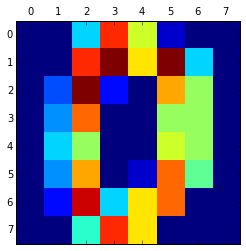

In [99]:
digits = datasets.load_digits(5)
digits.data /= 16.0
plt.matshow(digits.images[0])
plt.show()

n = digits.data.shape[0]

We are going to learn transfromation $f=Wx$ from 64-dimensional space to two-dimensional plane.

Our loss function should pull together two samples if their label is the same and repel them if they are close ($\|f_1-f_2\|<1$) and their labels differ. This task do not require the loss function itself, but you have to implement the computation of the gradient of this function.

I was using following loss function:

$
\begin{align*} 
    d(x_i, x_i', M) &=  (x_i - x_i')^T M^T M (x_i - x_i') \\
    l(x_i, x_i', y_i, M) &= y_i d(x_i, x_i', M) + (1 - y_i) \max(0, 1 - d(x_i, x_i', M)) \\
    \frac{\partial}{\partial M} (x^T M^T M x) &= 2 M x x^T
\end{align*}
$

I'm not completely sure whether my derivative is correct but it seems to work :)

In [169]:
def compute_grad_metric(w, x1, x2, label1, label2):
    dx = np.asmatrix(x1 - x2).T
    dist = dx.T.dot(w.T.dot(w)).dot(dx)
    grad = 2 * w.dot(dx).dot(dx.T)

    if label1 == label2:
        return grad
    else:
        if dist < 1:
            return -grad    
    return np.zeros(w.shape)

def compute_loss_metric(w, x1, x2, label1, label2):
    dx = np.asmatrix(x1 - x2).T
    dist = dx.T.dot(w.T.dot(w)).dot(dx)
    
    if label1 == label2:
        return dist
    else:
        return max(0, 1 - dist)

Optimize matrix $w$ with one of implemented in problem 1 methods.

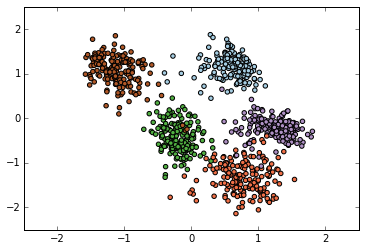

In [172]:
w = np.random.randn(2, 64)
w = w / np.linalg.norm(w)
v = np.zeros((2, 64))

alpha = 0.002
mu = 0.9

n_iter = 10000 # adjust if needed
n_vis  = 100   # adjust if needed

for i in range(n_iter):
    ind = random.sample(range(digits.data.shape[0]), 2)
    grad = compute_grad_metric(w + mu*v, digits.data[ind[0],:],
                                   digits.data[ind[1],:],
                                   digits.target[ind[0]],
                                   digits.target[ind[1]])
    
    v = mu * v - alpha * grad
    w = w + v
    
    if i % n_vis == 0:
        X = np.dot(w, digits.data.transpose())
        plt.clf()
        plt.scatter(X[0, :], X[1, :], c=digits.target, cmap=plt.cm.Paired)
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        display.clear_output(wait=True)
        display.display(plt.gcf())
plt.clf()